# 第5章: 係り受け解析
[日本語Wikipedia](https://ja.wikipedia.org/)の「[人工知能](https://ja.wikipedia.org/wiki/%E4%BA%BA%E5%B7%A5%E7%9F%A5%E8%83%BD)」に関する記事からテキスト部分を抜き出したファイルが[ai.ja.zip](/data/ai.ja.zip)に収録されている．
この文章を[CaboCha](https://taku910.github.io/cabocha/)や[KNP](http://nlp.ist.i.kyoto-u.ac.jp/index.php?KNP)等のツールを利用して係り受け解析を行い，その結果をai.ja.txt.parsedというファイルに保存せよ．このファイルを読み込み，以下の問に対応するプログラムを実装せよ．

In [1]:
from pprint import pprint

In [2]:
# cabochaがインストールできなかったので
# 森岡さんのページからもらってくる
!curl https://raw.githubusercontent.com/suzuhiki/NLP100knocks/refs/heads/main/data/ai.ja/ai.ja.parsed.txt -O

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0curl: (6) Could not resolve host: raw.githubusercontent.com


## 40. 係り受け解析結果の読み込み（形態素）
形態素を表すクラス`Morph`を実装せよ．このクラスは表層形（`surface`），基本形（`base`），品詞（`pos`），品詞細分類1（`pos1`）をメンバ変数に持つこととする．さらに，係り受け解析の結果（ai.ja.txt.parsed）を読み込み，各文を`Morph`オブジェクトのリストとして表現し，冒頭の説明文の形態素列を表示せよ．

In [2]:
class Morph(object):
    def __init__(self, line):
        surface, lat = line.split("\t")
        items = lat.split(",")
        self.surface = surface
        self.base = items[6]
        self.pos = items[0]
        self.pos1 = items[1]

In [3]:
with open("data/ai.ja.parsed.txt", "r") as f:
    sentences = f.read().split("EOS\n")
    chunks = list()
    for sentence in sentences:
        lines = sentence.rstrip().split("\n")
        morphs = list()
        for line in lines:
            if(line.startswith("*") or len(line) == 0):
                continue
            morphs.append(Morph(line))
        if(len(morphs)):
            chunks.append(morphs)

pprint([item.__dict__ for item in chunks[1]])
        

[{'base': '人工', 'pos': '名詞', 'pos1': '一般', 'surface': '人工'},
 {'base': '知能', 'pos': '名詞', 'pos1': '一般', 'surface': '知能'},
 {'base': '（', 'pos': '記号', 'pos1': '括弧開', 'surface': '（'},
 {'base': 'じん', 'pos': '名詞', 'pos1': '一般', 'surface': 'じん'},
 {'base': 'こうち', 'pos': '名詞', 'pos1': '一般', 'surface': 'こうち'},
 {'base': 'のう', 'pos': '助詞', 'pos1': '終助詞', 'surface': 'のう'},
 {'base': '、', 'pos': '記号', 'pos1': '読点', 'surface': '、'},
 {'base': '、', 'pos': '記号', 'pos1': '読点', 'surface': '、'},
 {'base': '*', 'pos': '名詞', 'pos1': '一般', 'surface': 'AI'},
 {'base': '〈', 'pos': '記号', 'pos1': '括弧開', 'surface': '〈'},
 {'base': '*', 'pos': '名詞', 'pos1': '固有名詞', 'surface': 'エーアイ'},
 {'base': '〉', 'pos': '記号', 'pos1': '括弧閉', 'surface': '〉'},
 {'base': '）', 'pos': '記号', 'pos1': '括弧閉', 'surface': '）'},
 {'base': 'と', 'pos': '助詞', 'pos1': '格助詞', 'surface': 'と'},
 {'base': 'は', 'pos': '助詞', 'pos1': '係助詞', 'surface': 'は'},
 {'base': '、', 'pos': '記号', 'pos1': '読点', 'surface': '、'},
 {'base': '「', 'pos': '記号', 'po

## 41. 係り受け解析結果の読み込み（文節・係り受け）
40に加えて，文節を表すクラス`Chunk`を実装せよ．このクラスは形態素（`Morph`オブジェクト）のリスト（`morphs`），係り先文節インデックス番号（`dst`），係り元文節インデックス番号のリスト（`srcs`）をメンバ変数に持つこととする．さらに，入力テキストの係り受け解析結果を読み込み，１文を`Chunk`オブジェクトのリストとして表現し，冒頭の説明文の文節の文字列と係り先を表示せよ．本章の残りの問題では，ここで作ったプログラムを活用せよ．


In [4]:
class Chunk(object):
    def __init__(self, morphs, dst, srcs):
        self.morphs = morphs
        self.dst = dst
        self.srcs = srcs

In [5]:

with open("data/ai.ja.parsed.txt", "r") as f:
    sentences = f.read().split("EOS\n")
    chunks = list()
    for sentence in sentences:
        sentence_chunk = list()
        lines = sentence.rstrip().split("\n")
        morphs = list()
        index = ""
        ids = [list() for _ in range(len(lines))]
        for line in lines:
            if(len(line) == 0):
                continue
            if(line.startswith("*")):
                if(len(morphs)):
                    items = index.split()
                    dst = int(items[2][:-1])
                    src = int(items[1])
                    if(dst != -1):
                        ids[dst].append(src)
                    sentence_chunk.append([morphs, dst])
                    morphs = list()
                index = line
                continue
            morphs.append(Morph(line))
        if(len(morphs)):
            items = index.split()
            dst = int(items[2][:-1])
            src = int(items[1])
            if(dst != -1):
                ids[dst].append(src)
            sentence_chunk.append([morphs, dst])
        if(len(sentence_chunk)):
            chunks.append([Chunk(morphs, dst, srcs) for (morphs, dst), srcs in zip(sentence_chunk, ids)])

        
pprint([[f"id: {i}", f"srcs: {item.srcs}", f"dst: {item.dst}", f"morphs: {[iitem.__dict__ for iitem in item.morphs]}"] for i, item in enumerate(chunks[1])])

        

[['id: 0',
  'srcs: []',
  'dst: 17',
  "morphs: [{'surface': '人工', 'base': '人工', 'pos': '名詞', 'pos1': '一般'}, "
  "{'surface': '知能', 'base': '知能', 'pos': '名詞', 'pos1': '一般'}]"],
 ['id: 1',
  'srcs: []',
  'dst: 17',
  "morphs: [{'surface': '（', 'base': '（', 'pos': '記号', 'pos1': '括弧開'}, "
  "{'surface': 'じん', 'base': 'じん', 'pos': '名詞', 'pos1': '一般'}, {'surface': "
  "'こうち', 'base': 'こうち', 'pos': '名詞', 'pos1': '一般'}, {'surface': 'のう', 'base': "
  "'のう', 'pos': '助詞', 'pos1': '終助詞'}, {'surface': '、', 'base': '、', 'pos': "
  "'記号', 'pos1': '読点'}, {'surface': '、', 'base': '、', 'pos': '記号', 'pos1': "
  "'読点'}]"],
 ['id: 2',
  'srcs: []',
  'dst: 3',
  "morphs: [{'surface': 'AI', 'base': '*', 'pos': '名詞', 'pos1': '一般'}]"],
 ['id: 3',
  'srcs: [2]',
  'dst: 17',
  "morphs: [{'surface': '〈', 'base': '〈', 'pos': '記号', 'pos1': '括弧開'}, "
  "{'surface': 'エーアイ', 'base': '*', 'pos': '名詞', 'pos1': '固有名詞'}, {'surface': "
  "'〉', 'base': '〉', 'pos': '記号', 'pos1': '括弧閉'}, {'surface': '）', 'base': "
  "'）'

## 42. 係り元と係り先の文節の表示
係り元の文節と係り先の文節のテキストをタブ区切り形式ですべて抽出せよ．ただし，句読点などの記号は出力しないようにせよ．


In [6]:
def show_src_dst(chunks):
    result = []
    for chunk in chunks:
        if(chunk.dst == -1):
            continue
        src = "".join([item.surface if item.pos != "記号" else '' for item in chunk.morphs])
        dst = "".join([item.surface if item.pos != "記号" else '' for item in chunks[chunk.dst].morphs])
        result.append(src + "\t" + dst)
    return result

for result in show_src_dst(chunks[1]):
    print(result)

# 抽出結果をファイルに出力
with open("./data/ai.ja.src.dst.txt", "w") as f:
    for result in chunks:
        lines = show_src_dst(result)
        if(len(lines)):
            f.write("\n".join(lines) + "\n")


人工知能	語
じんこうちのう	語
AI	エーアイとは
エーアイとは	語
計算	という
という	道具を
概念と	道具を
コンピュータ	という
という	道具を
道具を	用いて
用いて	研究する
知能を	研究する
研究する	計算機科学
計算機科学	の
の	一分野を
一分野を	指す
指す	語
語	研究分野とも
言語の	推論
理解や	推論
推論	問題解決などの
問題解決などの	知的行動を
知的行動を	代わって
人間に	代わって
代わって	行わせる
コンピューターに	行わせる
行わせる	技術または
技術または	研究分野とも
計算機	コンピュータによる
コンピュータによる	情報処理システムの
知的な	情報処理システムの
情報処理システムの	実現に関する
設計や	実現に関する
実現に関する	研究分野とも
研究分野とも	される


## 43. 名詞を含む文節が動詞を含む文節に係るものを抽出
名詞を含む文節が，動詞を含む文節に係るとき，これらをタブ区切り形式で抽出せよ．ただし，句読点などの記号は出力しないようにせよ．


In [7]:
def show_noun_verb(chunks):
    def check_part(morphs, part):
        for morph in morphs:
            if(morph.pos == part):
                return True
        return False
    
    result = []
    for chunk in chunks:
        if(check_part(chunk.morphs, "名詞") and check_part(chunks[chunk.dst].morphs, "動詞")):
            src = "".join([item.surface if item.pos != "記号" else '' for item in chunk.morphs])
            dst = "".join([item.surface if item.pos != "記号" else '' for item in chunks[chunk.dst].morphs])
            result.append(src + "\t" + dst)
    return result

for result in show_noun_verb(chunks[1]):
    print(result)

# 抽出結果をファイルに出力
with open("./data/ai.ja.noun.src.verb.dst.txt", "w") as f:
    for result in chunks:
        lines = show_noun_verb(result)
        if(len(lines)):
            f.write("\n".join(lines) + "\n")


道具を	用いて
知能を	研究する
一分野を	指す
知的行動を	代わって
人間に	代わって
コンピューターに	行わせる
研究分野とも	される


## 44. 係り受け木の可視化
与えられた文の係り受け木を有向グラフとして可視化せよ．可視化には，[Graphviz](http://www.graphviz.org/)等を用いるとよい．


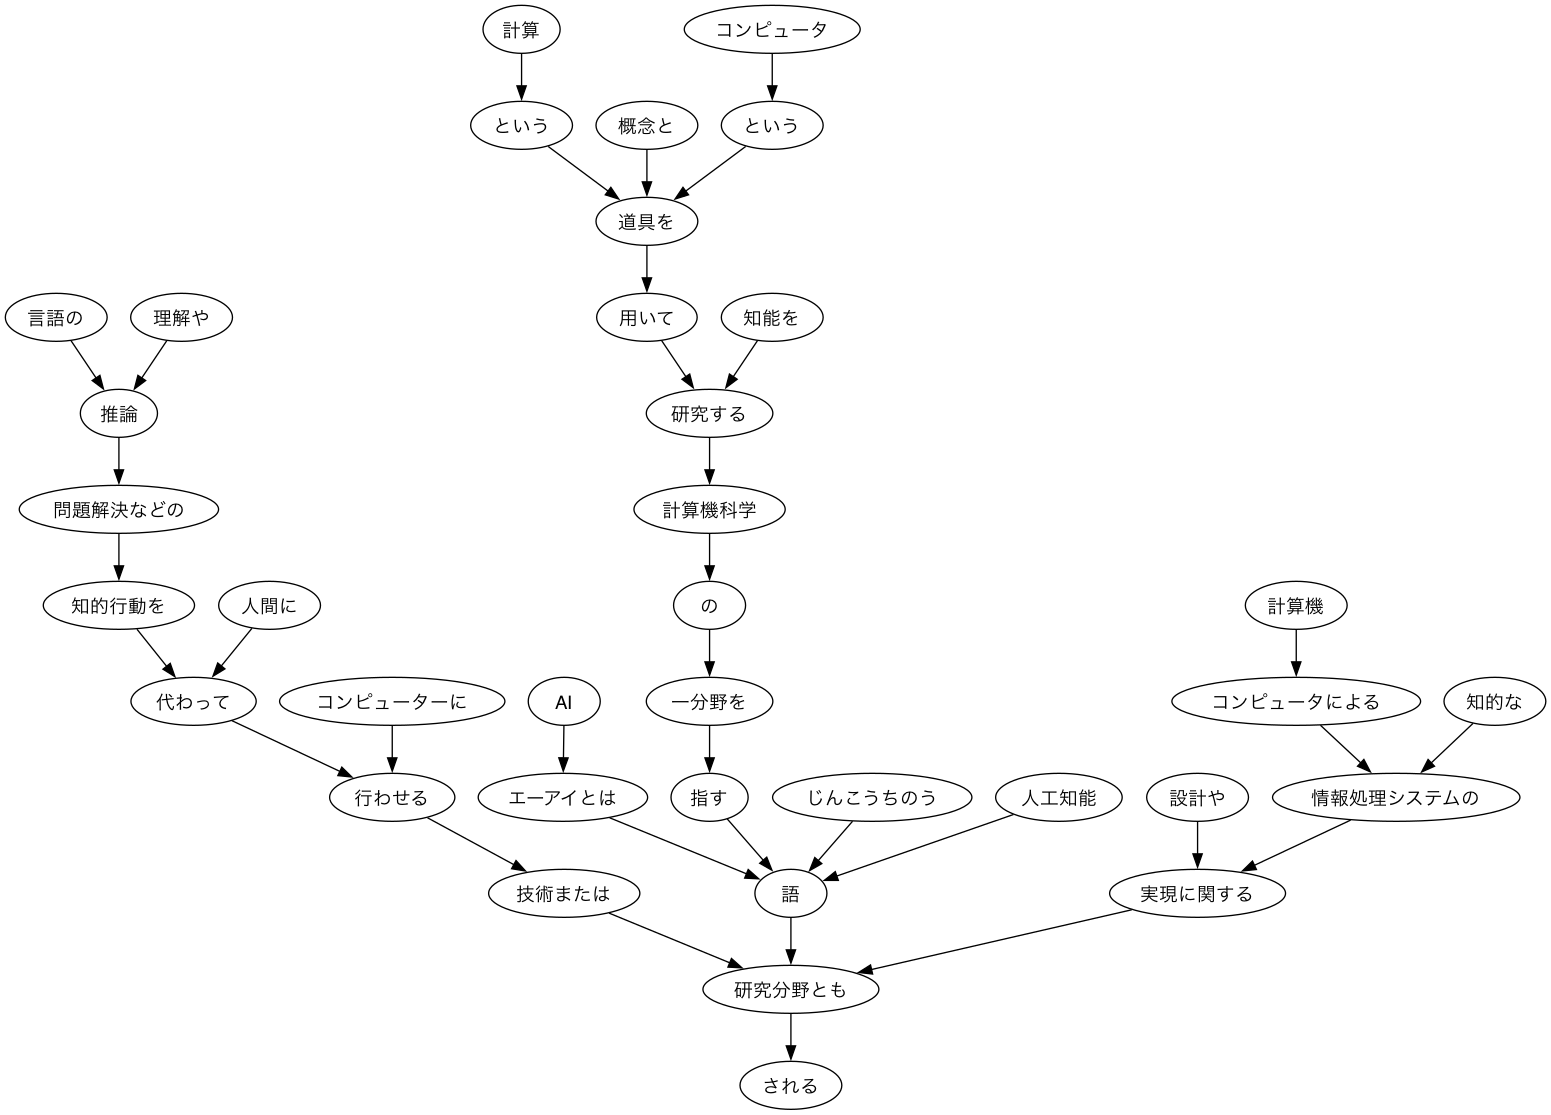

In [10]:
import graphviz

def show_tree(chunks):
    dot = graphviz.Digraph(format='png', comment='tree')
    dot.attr('node', fontname = 'Meiryo UI')
    dot.attr('edge', fontname = 'Meiryo UI')
    for i, chunk in enumerate(chunks):
        if(chunk.dst == -1):
            continue
        src = "".join([item.surface if item.pos != "記号" else '' for item in chunk.morphs])
        dst = "".join([item.surface if item.pos != "記号" else '' for item in chunks[chunk.dst].morphs])
        dot.node(str(i), src)
        dot.node(str(chunk.dst), dst)
        dot.edge(str(i), str(chunk.dst))
    dot.render('./data/tree.gv')

show_tree(chunks[1])

from IPython.display import Image

file_name = "./data/tree.gv.png"
Image(file_name)


## 45. 動詞の格パターンの抽出
今回用いている文章をコーパスと見なし，日本語の述語が取りうる格を調査したい．
動詞を述語，動詞に係っている文節の助詞を格と考え，述語と格をタブ区切り形式で出力せよ．
ただし，出力は以下の仕様を満たすようにせよ．

+ 動詞を含む文節において，最左の動詞の基本形を述語とする
+ 述語に係る助詞を格とする
+ 述語に係る助詞（文節）が複数あるときは，すべての助詞をスペース区切りで辞書順に並べる

「ジョン・マッカーシーはAIに関する最初の会議で人工知能という用語を作り出した。」という例文を考える．
この文は「作り出す」という１つの動詞を含み，「作り出す」に係る文節は「ジョン・マッカーシーは」，「会議で」，「用語を」であると解析された場合は，次のような出力になるはずである．

```
作り出す	で は を
```

このプログラムの出力をファイルに保存し，以下の事項をUNIXコマンドを用いて確認せよ．

+ コーパス中で頻出する述語と格パターンの組み合わせ
+ 「行う」「なる」「与える」という動詞の格パターン（コーパス中で出現頻度の高い順に並べよ）


In [24]:
f = open("./data/result45.txt", "w")

# 品詞partがmorphsに含まれるか判定
def check_part(morphs, part):
        for morph in morphs:
            if(morph.pos == part):
                return True
        return False

for sentence_chunk in chunks:
    for chunk in sentence_chunk:
        if(check_part(chunk.morphs, "動詞")):
            res = [item.base for item in chunk.morphs if item.pos == "動詞"]
            subs = []
            for id in chunk.srcs:
                items = [item.base for item in sentence_chunk[id].morphs if item.pos == "助詞"]
                if(len(items)):
                    subs += items[0] 
            for re in res:
                if(len(subs)):
                    f.write(f"{re}\t{' '.join(sorted(subs))}\n")

In [25]:
! grep "作り出す" data/result45.txt

作り出す	で は を


In [34]:
! sort data/result45.txt |uniq -c  | sort -r | head -n 5

  48 する	を
  17 する	が
  16 する	に
  15 する	と
  12 れる	と


In [28]:
! sort data/result45.txt |uniq -c  | sort -r | grep "行う"

   8 行う	を
   1 行う	は を
   1 行う	に を を
   1 行う	に に に よ り を
   1 行う	に
   1 行う	で を
   1 行う	で に を
   1 行う	で に ま を
   1 行う	て を
   1 行う	て に を
   1 行う	て に は は
   1 行う	て に
   1 行う	ぐ っ て は め を を
   1 行う	が で に
   1 行う	が で
   1 行う	が て で に
   1 行う	か ら


In [29]:
! sort data/result45.txt |uniq -c  | sort -r | grep "[0-9]*\sなる"

   4 なる	に は
   3 なる	が と
   2 なる	に
   2 なる	と
   1 なる	も
   1 なる	は は
   1 なる	に も
   1 なる	で に に
   1 なる	で と ど な
   1 なる	て は
   1 なる	て に は
   1 なる	て て に
   1 なる	っ て に に は よ
   1 なる	し て て と に は
   1 なる	が に に
   1 なる	が に
   1 なる	が で に
   1 なる	が で と に は は
   1 なる	が て と
   1 なる	が っ て と と に
   1 なる	が
   1 なる	か で と ら
   1 なる	か が て で と ら
   1 なる	か が て で で ら


In [30]:
! sort data/result45.txt |uniq -c  | sort -r | grep "与える"

   1 与える	に は を
   1 与える	が に
   1 与える	が ど な


## 46. 動詞の格フレーム情報の抽出
45のプログラムを改変し，述語と格パターンに続けて項（述語に係っている文節そのもの）をタブ区切り形式で出力せよ．45の仕様に加えて，以下の仕様を満たすようにせよ．

+ 項は述語に係っている文節の単語列とする（末尾の助詞を取り除く必要はない）
+ 述語に係る文節が複数あるときは，助詞と同一の基準・順序でスペース区切りで並べる

「ジョン・マッカーシーはAIに関する最初の会議で人工知能という用語を作り出した。」という例文を考える．
この文は「作り出す」という１つの動詞を含み，「作り出す」に係る文節は「ジョン・マッカーシーは」，「会議で」，「用語を」であると解析された場合は，次のような出力になるはずである．

```
作り出す	で は を	会議で ジョンマッカーシーは 用語を
```


In [13]:
f = open("./data/result46.txt", "w")

# 品詞partがmorphsに含まれるか判定
def check_part(morphs, part):
        for morph in morphs:
            if(morph.pos == part):
                return True
        return False

for sentence_chunk in chunks:
    for chunk in sentence_chunk:
        if(check_part(chunk.morphs, "動詞")):
            res = [item.base for item in chunk.morphs if item.pos == "動詞"]
            subs = ""
            for id in chunk.srcs:
                item = [item.base for item in sentence_chunk[int(id)].morphs if item.pos == "助詞"]
                if(len(item)):
                    subs += f" {item[0]}" 
            for id in chunk.srcs:
                subs += " " + "".join([item.surface for item in sentence_chunk[int(id)].morphs])
            for re in res:
                if(len(subs)):
                    f.write(re + "\t" + subs + "\n")

In [14]:
! cat data/result46.txt | grep "^作り出す"

作り出す	 は で を 出始めた。 ジョン・マッカーシーは 会議で 用語を


## 47. 機能動詞構文のマイニング
動詞のヲ格にサ変接続名詞が入っている場合のみに着目したい．46のプログラムを以下の仕様を満たすように改変せよ．

+ 「サ変接続名詞+を（助詞）」で構成される文節が動詞に係る場合のみを対象とする
+ 述語は「サ変接続名詞+を+動詞の基本形」とし，文節中に複数の動詞があるときは，最左の動詞を用いる
+ 述語に係る助詞（文節）が複数あるときは，すべての助詞をスペース区切りで辞書順に並べる
+ 述語に係る文節が複数ある場合は，すべての項をスペース区切りで並べる（助詞の並び順と揃えよ）

例えば「また、自らの経験を元に学習を行う強化学習という手法もある。」という文から，以下の出力が得られるはずである．

```
学習を行う	に を	元に 経験を
```


In [15]:
f = open("./data/result47.txt", "w")

# 品詞partがmorphsに含まれるか判定
def check_part(morphs, part):
        for morph in morphs:
            if(morph.pos == part):
                return True
        return False

def check_pos1(chunks, part):
    for chunk in chunks:
        for morph in chunk:
            if(morph.pos1 == part):
                return True
    return False

for sentence_chunk in chunks:
    for chunk in sentence_chunk:
        if(check_part(chunk.morphs, "動詞")):
            res = [item.base for item in chunk.morphs if item.pos == "動詞"]
            subs = ""
            if(not check_pos1([morph for morph in [sentence_chunk[int(i)].morphs for i in chunk.srcs]], "サ変接続")):
                continue
            for id in chunk.srcs:
                item = [item.base for item in sentence_chunk[int(id)].morphs if (item.pos == "助詞")]
                if(len(item)):
                    subs += f" {item[0]}" 
            for id in chunk.srcs:
                subs += " " + "".join([item.base for item in sentence_chunk[int(id)].morphs])
            for re in res:
                if(len(subs)):
                    f.write(re + "\t" + subs + "\n")

## 48. 名詞から根へのパスの抽出
文中のすべての名詞を含む文節に対し，その文節から構文木の根に至るパスを抽出せよ．
ただし，構文木上のパスは以下の仕様を満たすものとする．

+ 各文節は（表層形の）形態素列で表現する
+ パスの開始文節から終了文節に至るまで，各文節の表現を"` -> `"で連結する

「ジョン・マッカーシーはAIに関する最初の会議で人工知能という用語を作り出した。」という例文を考える．
CaboChaを係り受け解析に用いた場合，次のような出力が得られると思われる．

```
ジョンマッカーシーは -> 作り出した
AIに関する -> 最初の -> 会議で -> 作り出した
最初の -> 会議で -> 作り出した
会議で -> 作り出した
人工知能という -> 用語を -> 作り出した
用語を -> 作り出した
```

KNPを係り受け解析に用いた場合，次のような出力が得られると思われる．

```
ジョンマッカーシーは -> 作り出した
ＡＩに -> 関する -> 会議で -> 作り出した
会議で -> 作り出した
人工知能と -> いう -> 用語を -> 作り出した
用語を -> 作り出した
```

## 49. 名詞間の係り受けパスの抽出
文中のすべての名詞句のペアを結ぶ最短係り受けパスを抽出せよ．ただし，名詞句ペアの文節番号が$i$と$j$（$i<j$）のとき，係り受けパスは以下の仕様を満たすものとする．

+ 問題48と同様に，パスは開始文節から終了文節に至るまでの各文節の表現（表層形の形態素列）を"` -> `"で連結して表現する
+ 文節$i$と$j$に含まれる名詞句はそれぞれ，XとYに置換する

また，係り受けパスの形状は，以下の2通りが考えられる．

+ 文節$i$から構文木の根に至る経路上に文節$j$が存在する場合: 文節$i$から文節$j$のパスを表示
+ 上記以外で，文節$i$と文節$j$から構文木の根に至る経路上で共通の文節$k$で交わる場合: 文節$i$から文節$k$に至る直前のパスと文節$j$から文節$k$に至る直前までのパス，文節$k$の内容を"` | `"で連結して表示

「ジョン・マッカーシーはAIに関する最初の会議で人工知能という用語を作り出した。」という例文を考える．
CaboChaを係り受け解析に用いた場合，次のような出力が得られると思われる．

```
Xは | Yに関する -> 最初の -> 会議で | 作り出した
Xは | Yの -> 会議で | 作り出した
Xは | Yで | 作り出した
Xは | Yという -> 用語を | 作り出した
Xは | Yを | 作り出した
Xに関する -> Yの
Xに関する -> 最初の -> Yで
Xに関する -> 最初の -> 会議で | Yという -> 用語を | 作り出した
Xに関する -> 最初の -> 会議で | Yを | 作り出した
Xの -> Yで
Xの -> 会議で | Yという -> 用語を | 作り出した
Xの -> 会議で | Yを | 作り出した
Xで | Yという -> 用語を | 作り出した
Xで | Yを | 作り出した
Xという -> Yを
```

KNPを係り受け解析に用いた場合，次のような出力が得られると思われる．

```
Xは | Yに -> 関する -> 会議で | 作り出した。
Xは | Yで | 作り出した。
Xは | Yと -> いう -> 用語を | 作り出した。
Xは | Yを | 作り出した。
Xに -> 関する -> Yで
Xに -> 関する -> 会議で | Yと -> いう -> 用語を | 作り出した。
Xに -> 関する -> 会議で | Yを | 作り出した。
Xで | Yと -> いう -> 用語を | 作り出した。
Xで | Yを | 作り出した。
Xと -> いう -> Yを
```